In [79]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers
import pandas as pd
import math

%matplotlib inline

In [2]:
import os, pickle
import pickle

def cifar10(data_path):

    def _load_data_(files):
        X = np.empty([0, 3072])
        y = np.empty([0])
        for path in files:
            print(path)
            with open(path, "rb") as f:
                d = pickle.load(f, encoding='bytes')
                X = np.vstack([X, d[b"data"]]).astype("uint8")
                y = np.hstack([y, d[b"labels"]]).astype("uint8")
        return X, y
    
    training_files = [os.path.join(data_path, "data_batch_{0}".format(i))  for i in range(1, 6)]
    test_files = [os.path.join(data_path, "test_batch")]
    labels_file = os.path.join(data_path, "batches.meta")

    X_train, y_train = _load_data_(training_files)
    X_test, y_test = _load_data_(test_files)

    X_train = X_train.reshape([-1, 3, 32, 32]).transpose([0, 2, 3, 1])/255
    X_test = X_test.reshape([-1, 3, 32, 32]).transpose([0, 2, 3, 1])/255

    with open(labels_file, "rb") as f:
        labels = pickle.load(f, encoding="bytes")
    labels = [s.decode("utf-8")  for s in labels[b'label_names']]
    return X_train, X_test, y_train, y_test, labels

X_train, X_test, y_train, y_test, labels = cifar10("/data/cifar-10-batches-py/")
print("X_train:", X_train.shape, 
      "\nX_test:", X_test.shape, 
      "\ny_train: ", y_train.shape, 
      "\ny_test:", y_test.shape, 
      "\nlabels: ", labels)

/data/cifar-10-batches-py/data_batch_1
/data/cifar-10-batches-py/data_batch_2
/data/cifar-10-batches-py/data_batch_3
/data/cifar-10-batches-py/data_batch_4
/data/cifar-10-batches-py/data_batch_5
/data/cifar-10-batches-py/test_batch
X_train: (50000, 32, 32, 3) 
X_test: (10000, 32, 32, 3) 
y_train:  (50000,) 
y_test: (10000,) 
labels:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [3]:
pd.Series(y_test).value_counts()

7    1000
6    1000
5    1000
4    1000
3    1000
2    1000
9    1000
1    1000
8    1000
0    1000
dtype: int64

In [4]:
eye = np.eye(len(labels))
Y_train = eye[y_train]
Y_test = eye[y_test]
Y_train.shape, Y_test.shape

((50000, 10), (10000, 10))

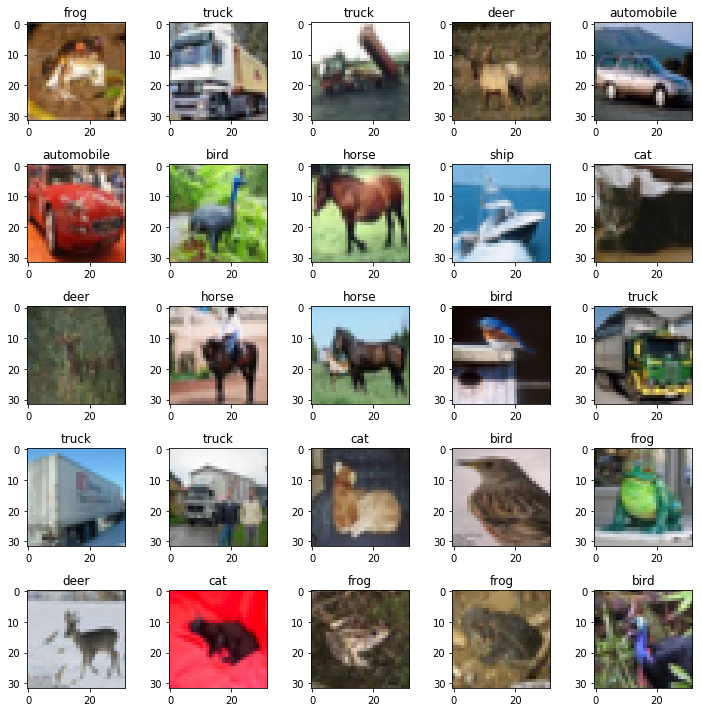

In [5]:
fig, _ = plt.subplots(5, 5, figsize= (10, 10))

for i, ax in enumerate(fig.axes):
    ax.imshow(X_train[i])
    label = labels[y_train[i]]
    ax.set_title(label)
    
plt.tight_layout()

Let's take a look at differente horse images

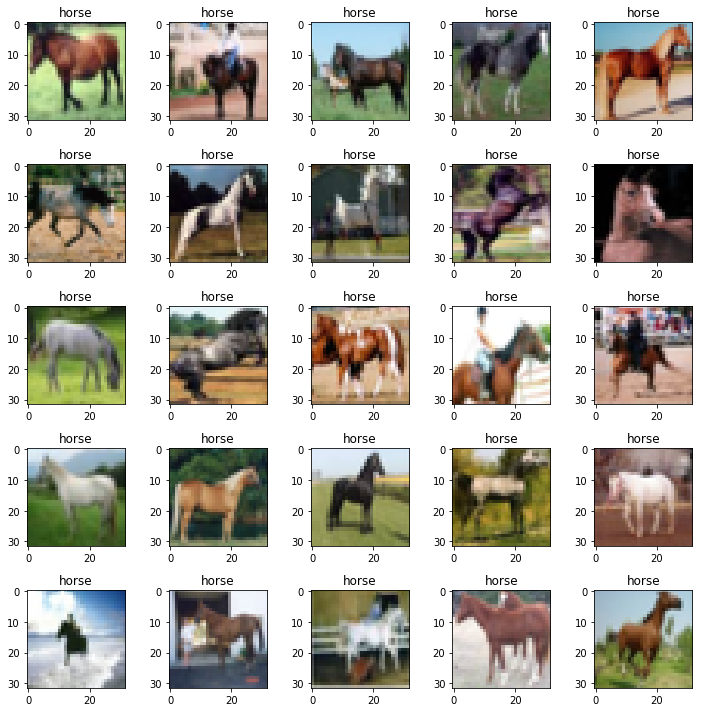

In [6]:
fig, _ = plt.subplots(5, 5, figsize= (10, 10))

for i, ax in enumerate(fig.axes):
    data_filter = y_train == 7
    ax.imshow(X_train[data_filter][i])
    label = labels[y_train[data_filter][i]]
    ax.set_title(label)
    
plt.tight_layout()

# LetNet Architecture

In [7]:
tf.set_random_seed(1)
np.random.seed(1)
num_classes = len(labels)

def build_model(input_shape, num_classes):
    with tf.device('/cpu:0'):
        model = keras.Sequential()
        model.add(layers.Conv2D(activation="relu", 
                                filters=32, 
                                kernel_size=(5, 5), 
                                input_shape = input_shape))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Conv2D(activation="relu", 
                            filters=64, 
                            kernel_size=(5, 5)))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Flatten())
        model.add(layers.Dropout(rate=0.8))
        model.add(layers.Dense(400, activation="relu"))
        model.add(layers.Dense(num_classes, activation="softmax"))
        model.compile(loss=keras.losses.categorical_crossentropy
                      , metrics=["accuracy"]
                      , optimizer="adam")
    return model

model = build_model(X_train.shape[1:], num_classes)
model.summary()

model.fit(x=X_train
          , y = Y_train
          , validation_data = (X_test, Y_test)
          , batch_size = 16
          , epochs=10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               640400    
__________

# AlexNet Architecture

In [7]:
from keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Dense, Flatten
from keras.regularizers import l2
from functools import partial
from keras.callbacks import TensorBoard
from time import time

from keras import backend as K


In [108]:
weight_decay = 1e-4
my_Conv2D = partial(Conv2D
                    #, kernel_regularizer = l2(weight_decay)
                    , activation = "relu"
                    , kernel_initializer="he_normal"
                    , padding = "SAME"
                   )


model = keras.Sequential()
model.add(my_Conv2D(32, (3,3), input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(my_Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(my_Conv2D(64, (3,3)))
model.add(BatchNormalization())
model.add(my_Conv2D(64, (3,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(my_Conv2D(128, (3,3)))
model.add(BatchNormalization())
model.add(my_Conv2D(128, (3,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(30, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy, metrics=["accuracy"], optimizer="adam")

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_19 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_20 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 64)        18496     
__________

# Training without image augmentationd (90% accuracy)

In [112]:
tf.set_random_seed(1)
np.random.seed(1)
batch_size = 128

tboard = TensorBoard(log_dir="/tmp/tf/log/%d" % time())
model.fit(X_train, Y_train
          , epochs=150
          , batch_size=batch_size
          , validation_data=(X_test, Y_test)
          , callbacks=[tboard])

Train on 50000 samples, validate on 10000 samples
Epoch 1/150
50000/50000 [==============================] - 52s 1ms/step - loss: 0.4025 - acc: 0.8605 - val_loss: 0.4289 - val_acc: 0.8568
Epoch 2/150
50000/50000 [==============================] - 52s 1ms/step - loss: 0.3372 - acc: 0.8818 - val_loss: 0.3443 - val_acc: 0.8847
Epoch 3/150
50000/50000 [==============================] - 52s 1ms/step - loss: 0.3110 - acc: 0.8914 - val_loss: 0.3608 - val_acc: 0.8792
Epoch 4/150
50000/50000 [==============================] - 52s 1ms/step - loss: 0.2910 - acc: 0.8985 - val_loss: 0.3443 - val_acc: 0.8866
Epoch 5/150
50000/50000 [==============================] - 52s 1ms/step - loss: 0.2758 - acc: 0.9030 - val_loss: 0.3656 - val_acc: 0.8812
Epoch 6/150
50000/50000 [==============================] - 52s 1ms/step - loss: 0.2605 - acc: 0.9087 - val_loss: 0.3479 - val_acc: 0.8900
Epoch 7/150
50000/50000 [==============================] - 52s 1ms/step - loss: 0.2447 - acc: 0.9136 - val_loss: 0.3600 - 

50000/50000 [==============================] - 52s 1ms/step - loss: 0.0917 - acc: 0.9669 - val_loss: 0.4520 - val_acc: 0.8888
Epoch 60/150
50000/50000 [==============================] - 52s 1ms/step - loss: 0.0952 - acc: 0.9663 - val_loss: 0.4156 - val_acc: 0.8926
Epoch 61/150
50000/50000 [==============================] - 52s 1ms/step - loss: 0.0880 - acc: 0.9689 - val_loss: 0.4377 - val_acc: 0.8918
Epoch 62/150
50000/50000 [==============================] - 52s 1ms/step - loss: 0.0867 - acc: 0.9688 - val_loss: 0.4413 - val_acc: 0.8925
Epoch 63/150
50000/50000 [==============================] - 52s 1ms/step - loss: 0.0867 - acc: 0.9695 - val_loss: 0.4267 - val_acc: 0.8946
Epoch 64/150
50000/50000 [==============================] - 52s 1ms/step - loss: 0.0833 - acc: 0.9710 - val_loss: 0.4367 - val_acc: 0.8938
Epoch 65/150
50000/50000 [==============================] - 52s 1ms/step - loss: 0.0853 - acc: 0.9694 - val_loss: 0.4277 - val_acc: 0.8947
Epoch 66/150
50000/50000 [==============

Epoch 118/150
50000/50000 [==============================] - 52s 1ms/step - loss: 0.0660 - acc: 0.9769 - val_loss: 0.5107 - val_acc: 0.8888
Epoch 119/150
50000/50000 [==============================] - 52s 1ms/step - loss: 0.0652 - acc: 0.9772 - val_loss: 0.4882 - val_acc: 0.8922
Epoch 120/150
50000/50000 [==============================] - 52s 1ms/step - loss: 0.0637 - acc: 0.9775 - val_loss: 0.4816 - val_acc: 0.8922
Epoch 121/150
50000/50000 [==============================] - 52s 1ms/step - loss: 0.0620 - acc: 0.9783 - val_loss: 0.4527 - val_acc: 0.8997
Epoch 122/150
50000/50000 [==============================] - 52s 1ms/step - loss: 0.0632 - acc: 0.9777 - val_loss: 0.4770 - val_acc: 0.8917
Epoch 123/150
50000/50000 [==============================] - 52s 1ms/step - loss: 0.0655 - acc: 0.9771 - val_loss: 0.4516 - val_acc: 0.8965
Epoch 124/150
50000/50000 [==============================] - 52s 1ms/step - loss: 0.0640 - acc: 0.9776 - val_loss: 0.4632 - val_acc: 0.8967
Epoch 125/150
50000/

# Training with image augmentation

In [12]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=90
                             , width_shift_range=0.1
                             , height_shift_range=0.1
                             , horizontal_flip=True) 
datagen.fit(X_train)

(16, 32, 32, 3) (16, 10)


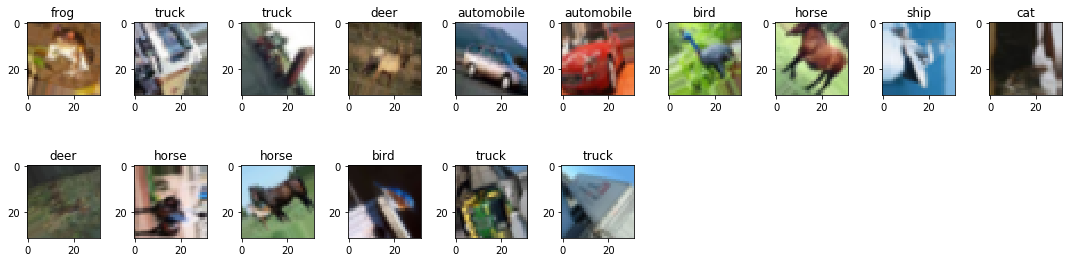

In [99]:
fig, _ = plt.subplots(4, 10, figsize = (15, 8))

for X_batch, Y_batch in datagen.flow(X_train, Y_train, batch_size=batch_size, shuffle=False):
    print(X_batch.shape, Y_batch.shape)
    
    for i, ax in enumerate(fig.axes):
        if i < len(images):
            ax.imshow(X_batch[i])
            ax.set_title(labels[Y_batch.argmax(axis=1)[i]])
        else:
            ax.remove()
    
    break

plt.tight_layout()


In [110]:
tf.set_random_seed(1)
np.random.seed(1)

batch_size = 128

tboard = TensorBoard(log_dir="/tmp/tf/log/%d" % time())
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size)
                      , steps_per_epoch = len(X_train)//batch_size 
                      , epochs=150
                      , shuffle = False
                      , validation_data=(X_test, Y_test)
                      , callbacks=[tboard])

Epoch 1/150
390/390 [==============================] - 51s 132ms/step - loss: 1.9146 - acc: 0.2783 - val_loss: 1.9280 - val_acc: 0.2850
Epoch 2/150
390/390 [==============================] - 51s 131ms/step - loss: 1.6394 - acc: 0.3838 - val_loss: 1.7631 - val_acc: 0.3895
Epoch 3/150
390/390 [==============================] - 51s 131ms/step - loss: 1.4519 - acc: 0.4665 - val_loss: 1.5667 - val_acc: 0.4652
Epoch 4/150
390/390 [==============================] - 51s 131ms/step - loss: 1.3395 - acc: 0.5130 - val_loss: 1.4018 - val_acc: 0.5046
Epoch 5/150
390/390 [==============================] - 51s 131ms/step - loss: 1.2628 - acc: 0.5423 - val_loss: 1.3339 - val_acc: 0.5406
Epoch 6/150
390/390 [==============================] - 51s 131ms/step - loss: 1.2090 - acc: 0.5641 - val_loss: 1.2339 - val_acc: 0.5684
Epoch 7/150
390/390 [==============================] - 51s 131ms/step - loss: 1.1572 - acc: 0.5842 - val_loss: 1.2391 - val_acc: 0.5856
Epoch 8/150
390/390 [===========================

Epoch 61/150
390/390 [==============================] - 51s 132ms/step - loss: 0.6593 - acc: 0.7697 - val_loss: 0.7301 - val_acc: 0.7574
Epoch 62/150
390/390 [==============================] - 51s 131ms/step - loss: 0.6639 - acc: 0.7682 - val_loss: 0.6387 - val_acc: 0.7845
Epoch 63/150
390/390 [==============================] - 51s 132ms/step - loss: 0.6546 - acc: 0.7739 - val_loss: 0.7410 - val_acc: 0.7571
Epoch 64/150
390/390 [==============================] - 51s 132ms/step - loss: 0.6609 - acc: 0.7708 - val_loss: 0.6860 - val_acc: 0.7699
Epoch 65/150
390/390 [==============================] - 51s 132ms/step - loss: 0.6558 - acc: 0.7706 - val_loss: 0.7169 - val_acc: 0.7617
Epoch 66/150
390/390 [==============================] - 51s 132ms/step - loss: 0.6469 - acc: 0.7728 - val_loss: 0.6606 - val_acc: 0.7797
Epoch 67/150
390/390 [==============================] - 51s 131ms/step - loss: 0.6528 - acc: 0.7738 - val_loss: 0.6151 - val_acc: 0.7929
Epoch 68/150
390/390 [===================

390/390 [==============================] - 51s 131ms/step - loss: 0.5688 - acc: 0.8008 - val_loss: 0.6302 - val_acc: 0.7945
Epoch 121/150
390/390 [==============================] - 51s 132ms/step - loss: 0.5631 - acc: 0.8037 - val_loss: 0.5769 - val_acc: 0.8093
Epoch 122/150
390/390 [==============================] - 51s 132ms/step - loss: 0.5658 - acc: 0.8057 - val_loss: 0.5748 - val_acc: 0.8103
Epoch 123/150
390/390 [==============================] - 51s 131ms/step - loss: 0.5677 - acc: 0.8013 - val_loss: 0.6378 - val_acc: 0.7920
Epoch 124/150
390/390 [==============================] - 51s 131ms/step - loss: 0.5672 - acc: 0.8026 - val_loss: 0.6458 - val_acc: 0.7913
Epoch 125/150
390/390 [==============================] - 51s 132ms/step - loss: 0.5706 - acc: 0.8004 - val_loss: 0.5592 - val_acc: 0.8115
Epoch 126/150
390/390 [==============================] - 51s 132ms/step - loss: 0.5542 - acc: 0.8064 - val_loss: 0.6454 - val_acc: 0.7888
Epoch 127/150
390/390 [=========================

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


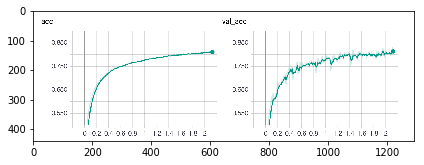

In [120]:
from skimage.io import imread
imshow(imread("/home/abasar/2018-04-30_0121.png"))

As we can see aftre 150 iterations still has not got saturation. More epochs will improve the performance of this model.